# Deriving the Regions
> Defining the Whisky producing regions of Scotland using distillery density and coastline constraints

Using just a list of distilleries (settlement and whisky region name), a geodecoder service, and a shapefile of the Scottish land masses, can I derive a map/shapefile of the Whisky producing regions of Scotland?

In [1]:
from typing import Any, Dict, List

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from whisky_regions import (ExpandToFillLandMass, Plotter, TownLocator,
                            TrimFromEachOther, TrimToLandMass)

## Import Scotland Land Data
Data retrieved from the [UK Data Service](https://borders.ukdataservice.ac.uk/).

In [2]:
uk_shape: gpd.GeoDataFrame = gpd.read_file(
    filename="~/Downloads/infuse_ctry_2011.shp",
    engine="pyogrio",
)
uk_shape.to_crs(
    epsg=3395,  # using mercator projection
    inplace=True,
)

scotland: gpd.GeoDataFrame = uk_shape[uk_shape["geo_label"] == "Scotland"]
scotland.head()

geo_code geo_label geo_labelw      label      name  \
1  S92000003  Scotland   Yr Alban  S92000003  Scotland   

                                            geometry  
1  MULTIPOLYGON (((-365866.377 7521373.240, -3658...

<Axes: >

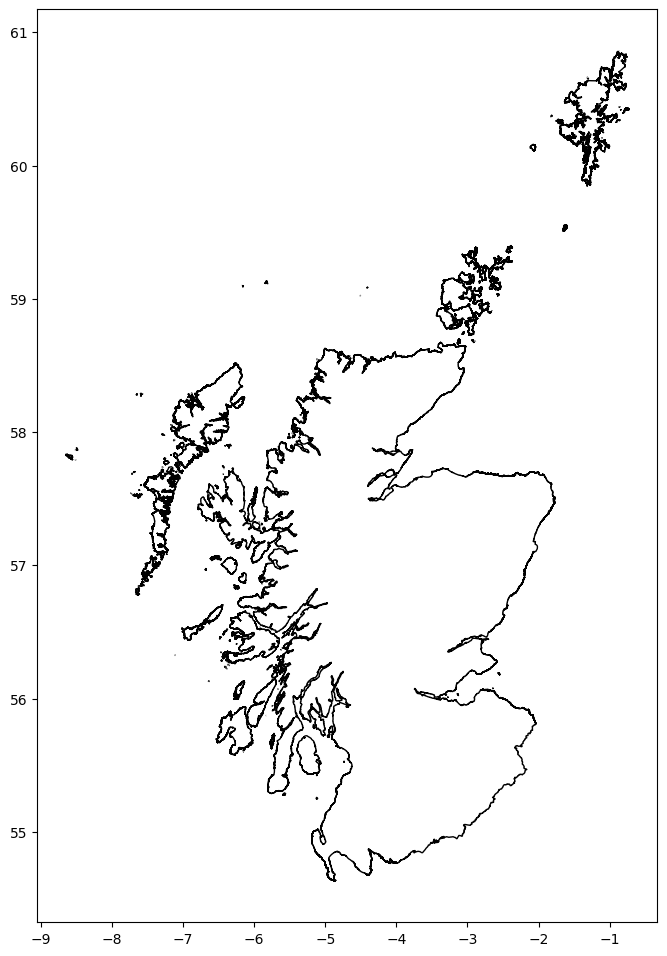

In [3]:
plotter = Plotter(
    base_map=scotland
)
plotter.plot

## Import Distillery Data and Augment
The data is retrieved from the [Wikipedia Article](https://en.wikipedia.org/wiki/List_of_whisky_distilleries_in_Scotland) on whisky distilleries. It is augmented with geolocations by looking up the towns on [OpenWeatherMap](https://openweathermap.org/api/geocoding-api).

The raw data has been adjusted in 3 places:
* Knockdhu and Dalmunach's locales couldn't be found with the API so more well known (relevant) town names were used
* Dalwhinnie can be classed as both Speyside and Highland, but was so far distant from other Speyside distilleries that I re-classed it as Highland

In [4]:
raw_distilleries: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="raw.csv"
)
raw_distilleries.head()

Distillery            Location    Region                 Owner
0      Aberargie           Aberargie   Lowland   Perth Distilling Co
1      Aberfeldy           Aberfeldy  Highland               Bacardi
2       Aberlour            Aberlour  Speyside         Pernod Ricard
3  Abhainn Dearg  Uig, Isle of Lewis    Island           Independent
4      Ailsa Bay              Girvan   Lowland  William Grant & Sons

In [5]:
locator = TownLocator()

distilleries: gpd.GeoDataFrame = gpd.GeoDataFrame(
    data=raw_distilleries,
    geometry=[locator.get_point(town=town) for town in raw_distilleries["Location"]],
    crs="EPSG:4326",
)
distilleries.to_crs(
    crs="EPSG:3395",
    inplace=True,
)
distilleries.rename_geometry(
    col="Lon/Lat",
    inplace=True,
)
distilleries.head()


Distillery            Location    Region                 Owner  \
0      Aberargie           Aberargie   Lowland   Perth Distilling Co   
1      Aberfeldy           Aberfeldy  Highland               Bacardi   
2       Aberlour            Aberlour  Speyside         Pernod Ricard   
3  Abhainn Dearg  Uig, Isle of Lewis    Island           Independent   
4      Ailsa Bay              Girvan   Lowland  William Grant & Sons   

                           Lon/Lat  
0  POINT (-373564.634 7588245.154)  
1  POINT (-430259.851 7646996.399)  
2  POINT (-359055.953 7820893.640)  
3  POINT (-709349.291 7845771.648)  
4  POINT (-540495.969 7373710.314)

<Axes: >

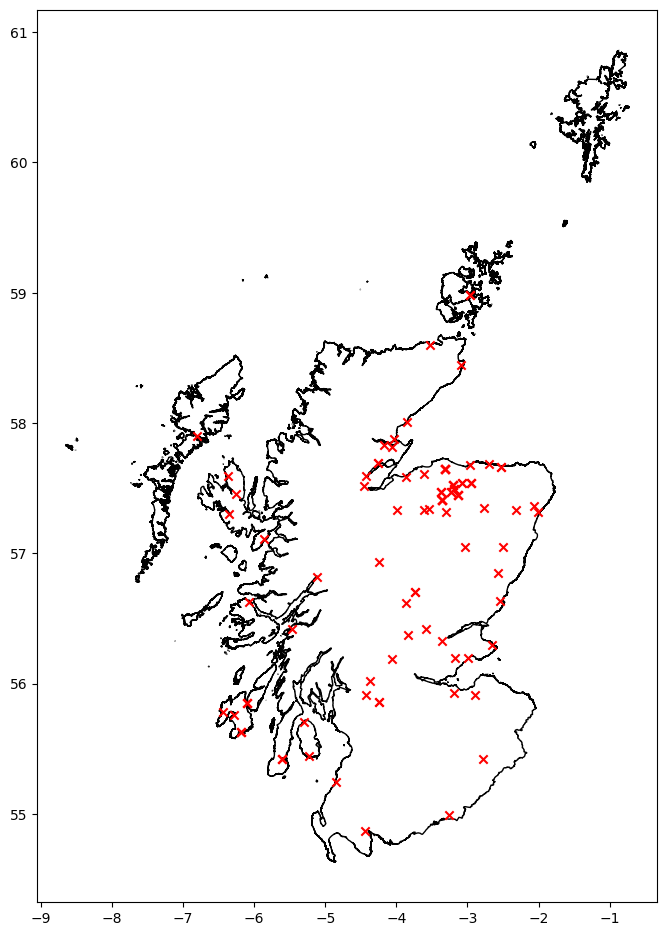

In [6]:
plotter = Plotter(
    base_map=scotland
)
plotter.add_distilleries(
    distilleries=distilleries
)
plotter.plot


## Extract Regions and Setup in Own GeoDataFrame

In [7]:
regions: gpd.GeoDataFrame = distilleries.dissolve(
    by="Region",
    aggfunc="count"
)
regions["Name"] = regions.index
regions.drop(
    labels=["Location", "Owner"],
    axis=1,
    inplace=True,
)
regions.rename(
    columns={"Distillery": "Distilleries"},
    inplace=True,
)
regions.head()

Lon/Lat  Distilleries  \
Region                                                                         
Campbeltown                    POINT (-623956.934 7409421.437)             3   
Highland     MULTIPOINT (-609303.760 7605992.277, -568951.0...            37   
Island       MULTIPOINT (-756878.528 7909698.146, -709349.2...            12   
Islay        MULTIPOINT (-717062.663 7479693.513, -700019.5...             9   
Lowland      MULTIPOINT (-540495.969 7373710.314, -494433.2...            15   

                    Name  
Region                    
Campbeltown  Campbeltown  
Highland        Highland  
Island            Island  
Islay              Islay  
Lowland          Lowland

<Axes: ylabel='Distilleries'>

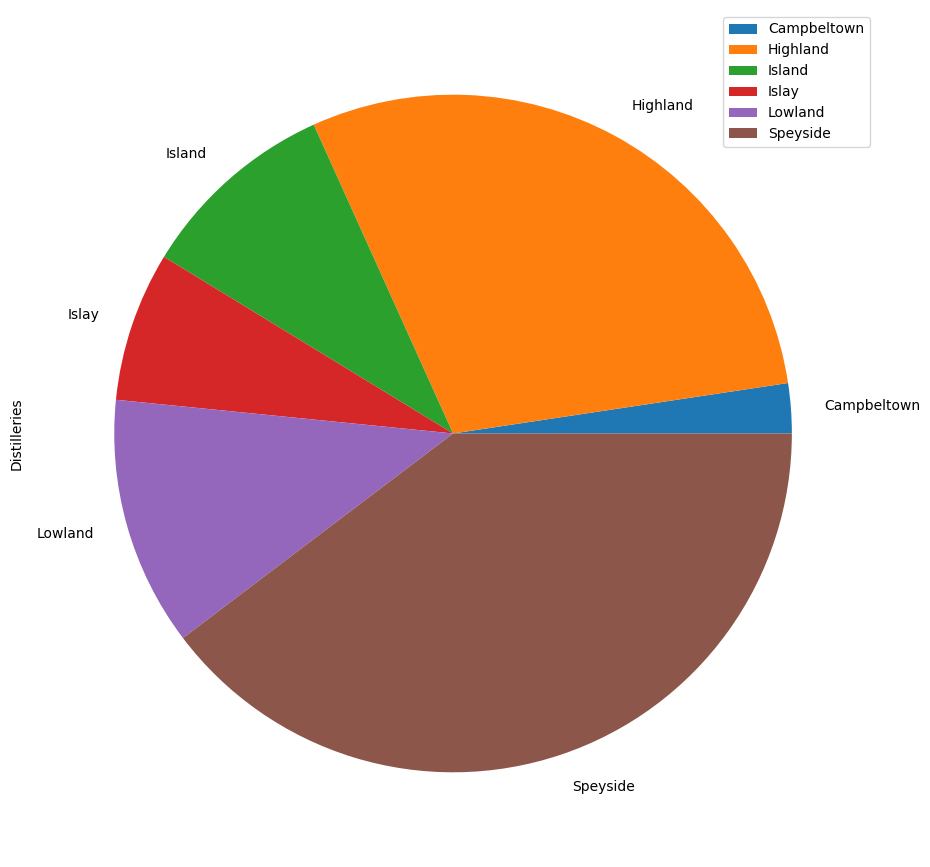

In [8]:
regions.plot.pie(
    y="Distilleries",
    figsize=(11, 11)
)

In [9]:
regions["Polygon"] = regions.convex_hull.buffer(distance=0.1)  # add buffer for campbeltown
regions.set_geometry(
    col="Polygon",
    inplace=True,
)
regions

Lon/Lat  Distilleries  \
Region                                                                         
Campbeltown                    POINT (-623956.934 7409421.437)             3   
Highland     MULTIPOINT (-609303.760 7605992.277, -568951.0...            37   
Island       MULTIPOINT (-756878.528 7909698.146, -709349.2...            12   
Islay        MULTIPOINT (-717062.663 7479693.513, -700019.5...             9   
Lowland      MULTIPOINT (-540495.969 7373710.314, -494433.2...            15   
Speyside     MULTIPOINT (-402221.254 7849692.524, -401908.0...            50   

                    Name                                            Polygon  
Region                                                                       
Campbeltown  Campbeltown  POLYGON ((-623956.834 7409421.437, -623956.834...  
Highland        Highland  POLYGON ((-355176.212 7508716.899, -355176.217...  
Island            Island  POLYGON ((-582684.492 7413678.664, -582684.496...  
Islay              Islay  POLYGON ((-688846.180 7449692.207, -688846.183...  
Lowland          Lowland  POLYGON ((-494433.227 7301453.443, -494433.236...  
Speyside        Speyside  POLYGON ((-368200.629 7789523.433, -368200.637...

<Axes: >

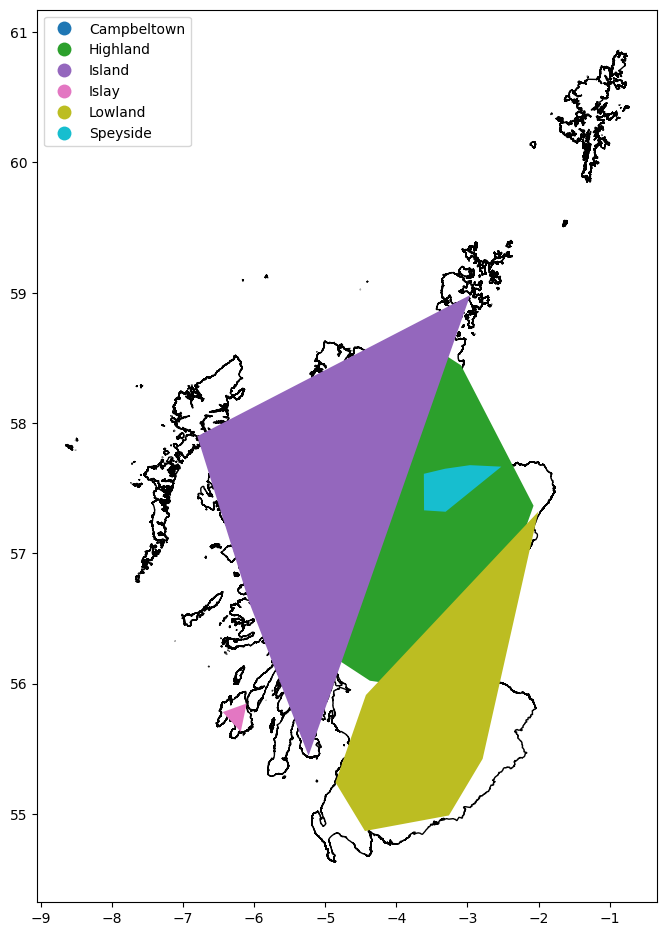

In [10]:
plotter = Plotter(
    base_map=scotland
)
plotter.add_regions(
    regions=regions
)
plotter.plot

This roughly shows the regions (inferred from the general areas). There are however overlapping regions. The next steps in order are:

1. Clip regions to underlying land masses
2. Clip regions from each other to get rid of overlaps
3. Expand clipped regions to cover remainder of land mass

## Trim Regions to Fit Land Mass

In [11]:
trimmer = TrimToLandMass(
    base_land_mass=scotland,
    layer=regions,
)

regions = trimmer.trim()

<Axes: >

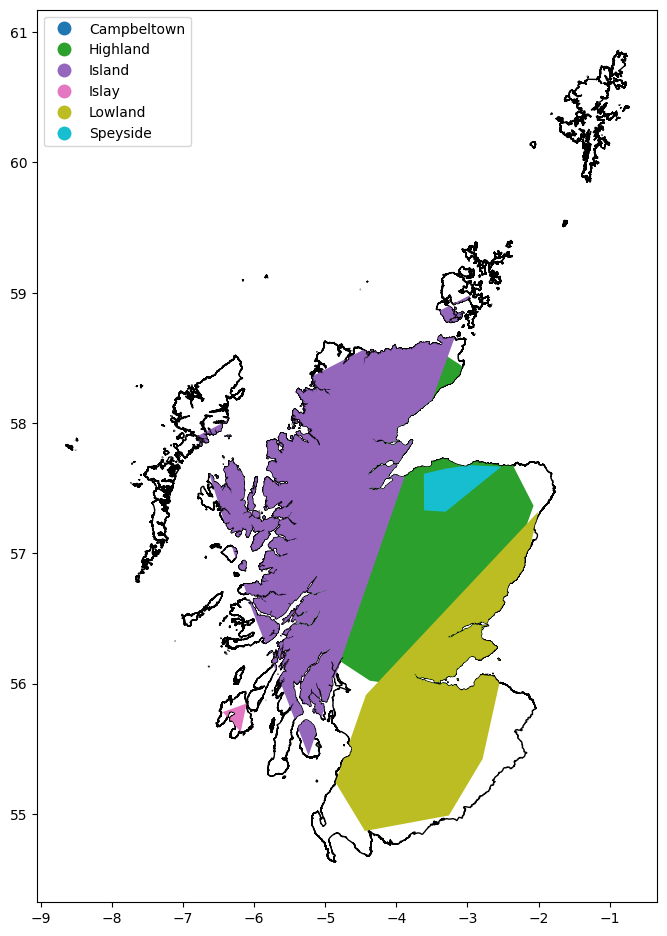

In [12]:
plotter = Plotter(
    base_map=scotland
)
plotter.add_regions(
    regions=regions
)
plotter.plot

## Trim Regions by Each Other to Eliminate Overlap

There could be many ways to trim the regions; however, in this case I'll be trimming using the "most distilleries wins" strategy.

In [13]:
trimmer = TrimFromEachOther(
    regions=regions,
)
regions = trimmer.trim()

/home/nicholas/whisky_region_mapping/whisky_regions/trim_from_each_other.py:38: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  ]["Polygon"].unary_union


<Axes: >

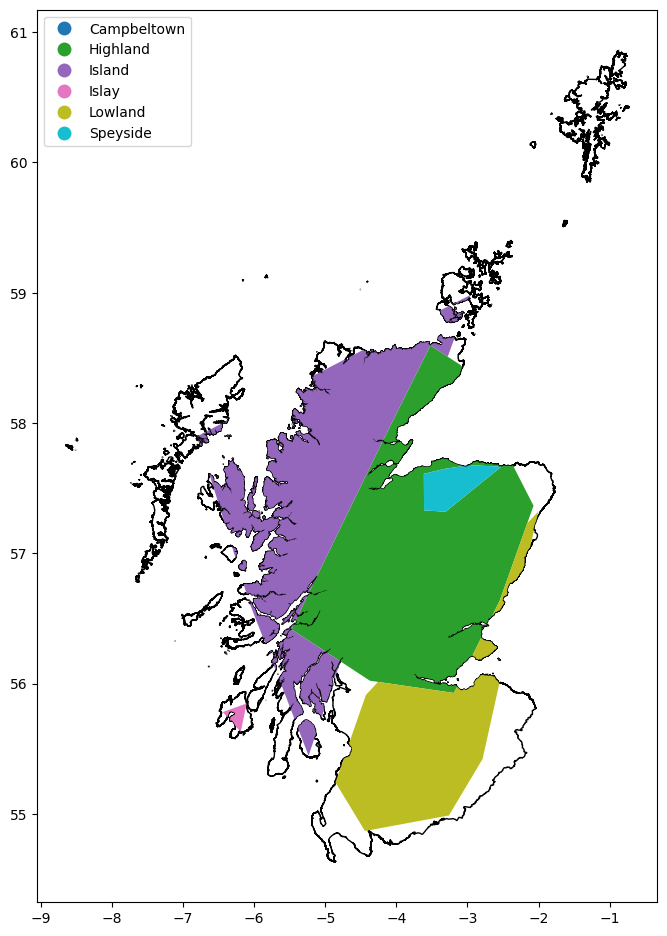

In [14]:
plotter = Plotter(
    base_map=scotland
)
plotter.add_regions(
    regions=regions
)
plotter.plot

## Expand Polygons to Fill Scotland
Find empty polygons by comparing land mass with regions, then for each polygon found running a tournament to find which region should lay claim to it. The current tournament strategy is "closest centroids wins".

In [ ]:
expander = ExpandToFillLandMass(
    base_land_mass=scotland,
    layer=regions,
)
regions = expander.expand()

2271/2274


## Replot Distilleries

In [ ]:
plotter = Plotter(
    base_map=scotland
)
plotter.add_regions(
    regions=regions
)
plotter.add_distilleries(
    distilleries=distilleries
)
plotter.save_figure("distilled")
plotter.plot

## Clean up GeoDataFrame and Export to Shapefile

In [ ]:
regions.drop(
    labels=["Lon/Lat", "Name", "Centroid"],
    axis=1,
    inplace=True
)
regions.rename(
    columns={"Distilleries": "Distillery"},  # rename to handle shapefile limits
    inplace=True,
)
regions.to_file(
    filename="output/whisky_regions.shp"
)

## Next Steps
The "closest region" polygon absorption strategy is flawed in that small dense regions such as Campbeltown are poaching polygons from less dense regions such as the Lowlands. Additionally, a significant amount of the Highlands is being classified as Islands, which is patently not true.

Potential fixes and further explorations:
* Weight the centroid to centroid polygon grabbing distance by number of distilleries
* Add an "is touching" test?
* Add Geographical restrictions (ie Islands being fully bounded, Speyside must be near the Spey etc)
* Test in reverse; ie how do the regions hold up when being used to classify distilleries
* Are there other GeoPandas techniques (instead of `convex_hull`)?
* Break out Polygon Grabbing algorithm into it's own class
* Voronoi, dealuney triangulation
* Plotting using Folium